# Plots

## This method has been referred from : https://gist.github.com/samuelsmal/815d59a8648d4abfce1f90b2f39089d5

In [64]:
# %load plot.py
import operator
import matplotlib.patches as mpatches
from itertools import groupby
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def plot_confusion_matrix(cm, labels, title, cmap=plt.cm.Blues):
    #cmap=cmap=plt.cm.binary
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #cax = ax.matshow(cm)
    #fig.colorbar(cax)

    #c = ax.pcolor(cm, cmap=cmap)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    #show_values_conf_matr(c)
    ax.set_xticklabels([""] + list(labels), rotation=90)
    ax.set_yticklabels([""] + list(labels))
    plt.tight_layout()
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.title(title)
    ax.tick_params(axis='both', which='both', length=0)

    width, height = cm.shape

    colour_threshold = np.amax(cm) / 2

    for x in range(width):
        for y in range(height):
            if cm[x][y] > 0:
                if cm[x][y] > colour_threshold:
                    color = 'white'
                else:
                    color = 'black'

                ax.text(y,
                        x,
                        str(cm[x][y]),
                        verticalalignment='center',
                        horizontalalignment='center',
                        color=color,
                        fontsize=15)

                       #bbox=dict(facecolor='white', edgecolor='white', boxstyle='circle'),
                       #color='black',
                       #fontsize=15)


def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: http://stackoverflow.com/a/25074150/395857
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=20, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
#     c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Remove last blank column
    plt.xlim((0, AUC.shape[1]))

    # Turn off all the ticks
    ax = plt.gca()
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    # resize
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))
    
def plot_classification_report(classification_report, title, cmap=plt.cm.Blues):
    '''
    Plot scikit-learn classification report.
    Extension based on http://stackoverflow.com/a/31689645/395857
    '''
    lines = classification_report.split('\\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        #print(v)
        plotMat.append(v)

    #print('plotMat: {0}'.format(plotMat))
    #print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 15
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat),
            title + ' classification report',
            xlabel,
            ylabel,
            xticklabels,
            yticklabels,
            figure_width,
            figure_height,
            correct_orientation,
            cmap=cmap)


def plot_probs(model, X_train, X_test, y_train, y_test, title, classes):
    colours = ['r', 'g', 'b', 'y', 'm']

    def get_coords(y_p, y_t):
        coords_with_colour = []

        for y_pred, y_true in zip(y_p, y_t):

            max_idx = np.argmax(y_pred)
            coord_x = np.max(y_pred)

            if max_idx == y_true:
                coord_y = 1
            else:
                coord_y = 0

            coords_with_colour.append((coord_x, coord_y, colours[y_true], y_true))

        return coords_with_colour


    f, axarr = plt.subplots(len(np.unique(y_train)), 2, sharex=True, sharey=True)
    for k, g in groupby(get_coords(model.predict_proba(X_train), y_train), key=operator.itemgetter(3)):
        for c in g:
            axarr[k - 1, 0].plot(c[0], c[1], 'o', markerfacecolor='white', markeredgecolor='black')
            axarr[k - 1, 0].set_ylim([-1, 2])
            axarr[k - 1, 0].set_xlim([-0.1, 1.1])
            axarr[k - 1, 0].set_yticks([0, 1])
            #axarr[k - 1, 0].set_ylabel(le.classes_[k], rotation=0, size='large')

    for k, g in groupby(get_coords(model.predict_proba(X_test), y_test), key=operator.itemgetter(3)):
        #axarr[k - 1, 1].set_label_position('right')
        f.text(0.95, 0.18 + k * 0.16, classes[k], weight='normal') #, ha='left', va='center')

        for c in g:
            axarr[k - 1, 1].plot(c[0], c[1], 'o', markerfacecolor='white', markeredgecolor='black')
            axarr[k - 1, 1].set_ylim([-1, 2])
            axarr[k - 1, 1].set_xlim([-0.1, 1.1])

    f.text(0.5, 0.04, 'probability', ha='center', va='center')
    f.text(0.06, 0.5, 'correct (1.0), not correct (0.0)', ha='center', va='center', rotation='vertical')

    plot_title = title + ' confidence'

    f.suptitle(plot_title, horizontalalignment='center', y=1, fontsize=14)

    axarr[0][0].set_title('training')
    axarr[0][1].set_title('testing')

    f.set_size_inches(*cm2inch(30), *cm2inch(15))

In [65]:
def cfr(p, X, Y):
    Xva = X
    Yva = Y
    Yva_hat = p.predict(Xva)
#     print(metrics.classification_report(Yva, Yva_hat))
#     print(metrics.confusion_matrix(Yva, Yva_hat))
    return metrics.classification_report(Yva, Yva_hat)

def confmat(p, X, Y):
    Xva = X
    Yva = Y
    Yva_hat = p.predict(Xva)
#     print(metrics.classification_report(Yva, Yva_hat))
#     print(metrics.confusion_matrix(Yva, Yva_hat))
    return metrics.confusion_matrix(Yva, Yva_hat)

ValueError: not enough values to unpack (expected 2, got 1)

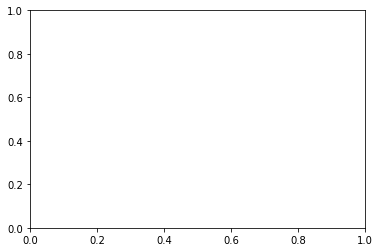

In [66]:
import joblib
xgbPipeline = joblib.load('xgb_grid_model.pkl')
classreport = cfr(xgbPipeline,Xts,Yts)
plot_classification_report(classreport,"XGB")